In [1]:
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import time

# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        print("full dataset size : ",len(self.data))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        img_path = "../data"+self.data.iloc[idx, 1][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        # mask_rle = self.data.iloc[idx, 2]
        # mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        # if self.transform:
        #     augmented = self.transform(image=image, mask=mask)
        #     image = augmented['image']
        #     mask = augmented['mask']

        # return image, mask
        assert False , "SatelliteDataset class must be used as test dataset obj"

class TV_SatelliteDataset(Dataset):
    def __init__(self,transform=None, is_train = True):
        self.is_train = is_train
        
        self.transform = transform
    def __len__(self):
        if self.is_train:
            return 114240-11424  ###### 조심할것.
        return 11424

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        if not self.is_train:
            idx += 102816
        img_path = "../split_data_224/train_img"+f"/{idx//16}_{idx%16}.png"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = "../split_data_224/train_mask"+f"/{idx//16}_{idx%16}.png"
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        #print("hello" , mask.shape)

        
        #print("hello" , mask.shape)

        
        #assert fsize != lsize , f"{fsize} should be different from {lsize}"

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [2]:
train_dataset = TV_SatelliteDataset(transform=transform, is_train=True)
val_dataset = TV_SatelliteDataset(transform=transform, is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)

In [3]:
def printtraindataset(dataset,idx = 0):
    clear_output()
    sample = dataset[idx]
    image, mask = sample
    #print(type(image))
# 이미지와 마스크 시각화
    plt.subplot(1, 3, 1)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title("image")

    img_path = "../split_data_224/train_img"+f"/{idx//16}_{idx%16}.png"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.title(f"org image{idx}")



    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("mask")
    plt.show()
    #print(len(image),len(image[0]), len(mask), len(mask[0]))
    #print(mask.shape)
    #print(image.shape)
    time.sleep(1)
# for i in range(4):
#     printdataset(train_dataset, i)

In [4]:
test_dataset = SatelliteDataset(csv_file='../data/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

full dataset size :  60640


In [5]:
def printtest(search_idx=0, csvpath = '../submit/deeplabv3plus_bbrn101_224split.csv'):
    clear_output()
    traindata = pd.read_csv('../data/test.csv')
    img_path = "../data"+traindata.iloc[search_idx, 1][1:]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    
    traindata = pd.read_csv(csvpath)
    mask_rle = traindata.iloc[search_idx, 1]
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("mask")
    plt.show()
    print(len(image),len(image[0]), len(mask), len(mask[0]))
    time.sleep(1)

In [9]:
def printtestdataset(dataset,idx = 0):
    
    sample = dataset[idx]
    image = sample
    #print(type(image))
# 이미지와 마스크 시각화
    plt.subplot(1, 3, 1)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title(f"image{idx}")

    traindata = pd.read_csv('../data/test.csv')
    img_path = "../data"+traindata.iloc[idx, 1][1:]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.title(f"org image{idx}")
    
    traindata = pd.read_csv('../submit/huggingfacemodel_0.csv')
    mask_rle = traindata.iloc[idx, 1]
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("mask")
    plt.show()
    if idx%20 == 0 and idx!=0:
        time.sleep(20)
        clear_output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


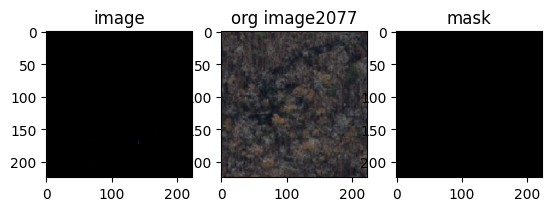

KeyboardInterrupt: 

In [21]:
for i in range(200,4000):
    printtraindataset(train_dataset, i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


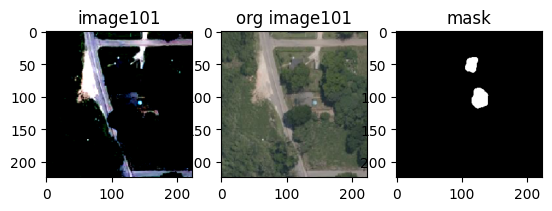

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


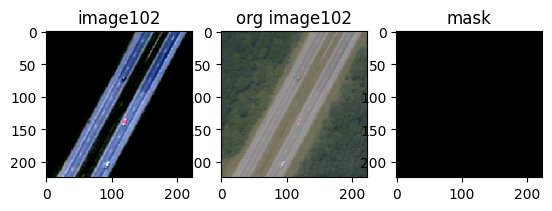

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


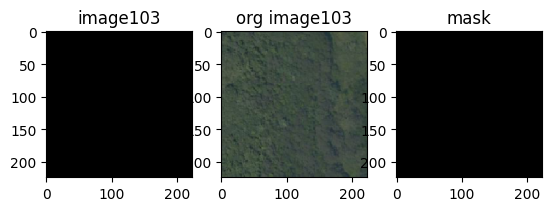

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


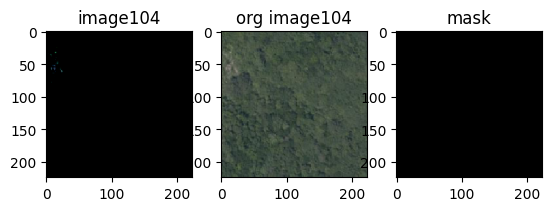

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


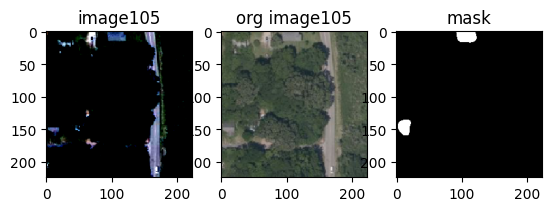

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


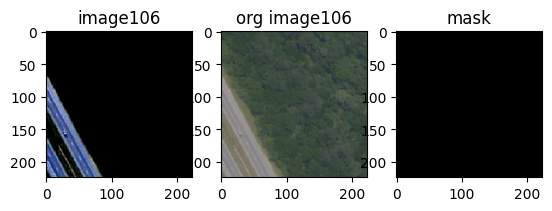

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


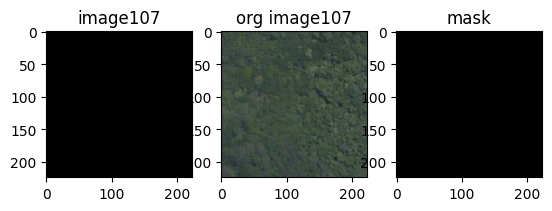

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


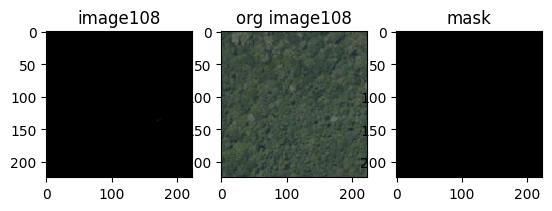

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


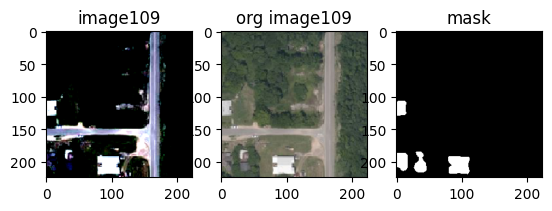

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


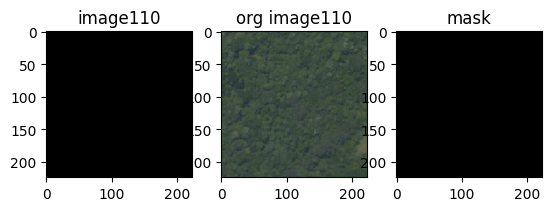

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


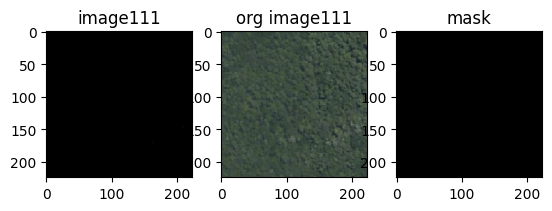

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


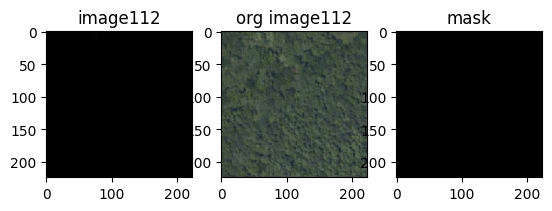

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


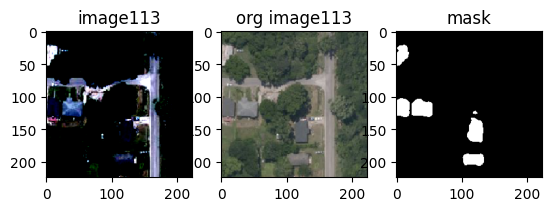

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


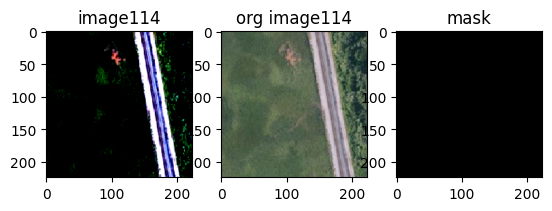

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


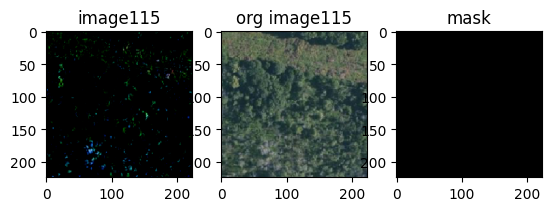

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


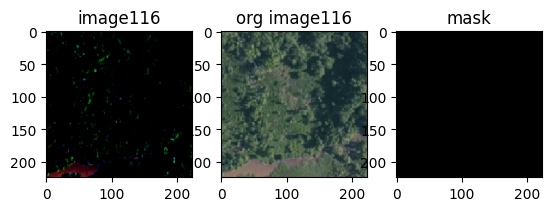

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

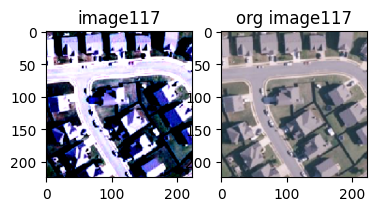

In [10]:
for i in range(400):
    printtestdataset(test_dataset, i)